In [1]:
import numpy as np
import pandas as pd
from numpy import genfromtxt
from copy import deepcopy
from pprint import pprint
import operator

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

np.random.seed = 42

## Dataset 2

In [2]:
data2 = pd.read_csv('datasets/housing_data.csv')
data2 = np.asarray(data2)

cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [3]:
data2.shape

(505, 14)

### Plot/visualize

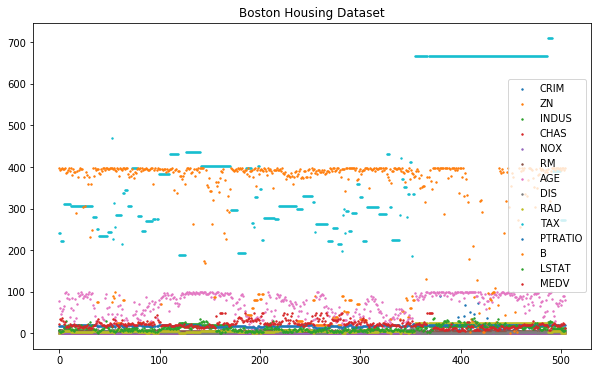

In [4]:
for idx, col in enumerate(cols):
    feature = data2[:, idx]
    plt.scatter(np.arange(len(feature)), feature, label=col, s=2)
    
plt.title('Boston Housing Dataset')
plt.legend()
plt.show()

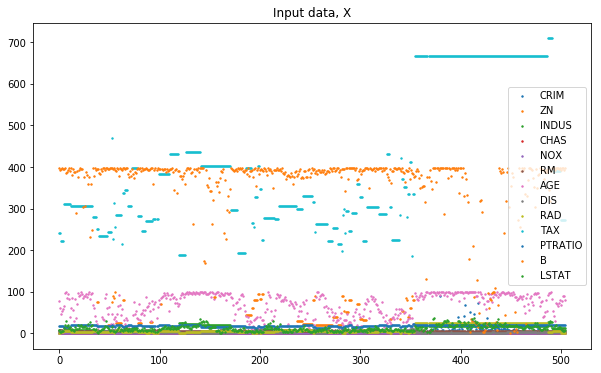

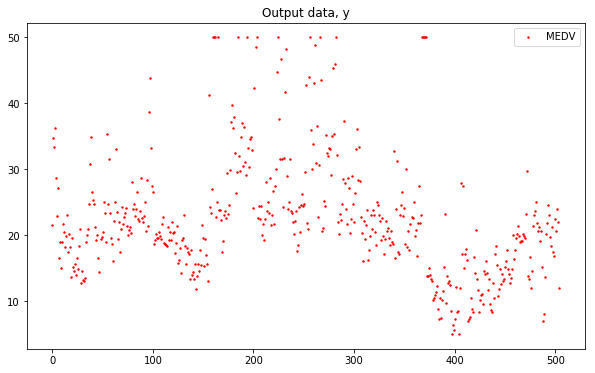

In [5]:
medv_idx = cols.index('MEDV')
y_ = data2[:, medv_idx]

data2_copy = np.copy(data2)
data2_copy = np.delete(data2_copy, medv_idx, axis=1)

X_ = data2_copy

for idx, col in enumerate(cols):
    if idx == medv_idx:
        pass
    elif idx > medv_idx:
        feature = X_[:, idx-1]
        plt.scatter(np.arange(len(feature)), feature, label=col, s=2)
    else:
        feature = X_[:, idx]
        plt.scatter(np.arange(len(feature)), feature, label=col, s=2)
    
plt.title('Input data, X')
plt.legend()
plt.show()

plt.scatter(np.arange(len(y_)), y_, label='MEDV', s=2, c='r')
plt.title('Output data, y')
plt.legend()
plt.show()

### Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def rmse(y_1, y_2):
    return mean_squared_error(y_1, y_2)

In [7]:
# randomly shuffling arrays
p = np.random.RandomState(seed=42).permutation(X_.shape[0])
X = X_[p]
y = y_[p]

print(X.shape)
print(X)
print(y.shape)

(505, 13)
[[8.44700e-02 0.00000e+00 4.05000e+00 ... 1.66000e+01 3.93230e+02
  9.64000e+00]
 [9.60400e-02 4.00000e+01 6.41000e+00 ... 1.76000e+01 3.96900e+02
  2.98000e+00]
 [1.05740e-01 0.00000e+00 2.77400e+01 ... 2.01000e+01 3.90110e+02
  1.80700e+01]
 ...
 [2.89900e-02 4.00000e+01 1.25000e+00 ... 1.97000e+01 3.89850e+02
  5.89000e+00]
 [1.44208e+01 0.00000e+00 1.81000e+01 ... 2.02000e+01 2.74900e+01
  1.80500e+01]
 [2.11610e-01 0.00000e+00 8.56000e+00 ... 2.09000e+01 3.94470e+02
  1.34400e+01]]
(505,)


##### Vanilla Linear Regression

In [8]:
model = LinearRegression()

kf = KFold(n_splits=10)
rmse_per_fold_train = []
rmse_per_fold_test = []
i = 0
for trainset, testset in kf.split(X):
    X_train, X_test = X[trainset], X[testset]
    y_train, y_test = y[trainset], y[testset]
    model.fit(X_train, y_train)
    rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))
    rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
    i = i + 1
    
rmse_avg_train = np.sqrt(np.average(rmse_per_fold_train))
rmse_avg_test = np.sqrt(np.average(rmse_per_fold_test))

print('--')
print('RMSE Training average = {}'.format(rmse_avg_train))
print('RMSE Testing average  = {}'.format(rmse_avg_test))

--
RMSE Training average = 4.666996300222979
RMSE Testing average  = 4.852811153002266


In [9]:
print(model.coef_)
print(np.max(model.coef_))
print(np.min(model.coef_))
print(np.var(model.coef_))

[-1.29203110e-01  4.75684568e-02  2.08100298e-03  3.48405162e+00
 -1.62837054e+01  3.69869272e+00  3.87169425e-03 -1.56550900e+00
  3.05970877e-01 -1.26576578e-02 -8.91182774e-01  8.58959219e-03
 -5.65851169e-01]
3.6986927238430107
-16.283705434207974
21.828303309504598


##### Finding significance of each feature

In [10]:
rmse_sig_train = {}
rmse_sig_test = {}

cols_trimmed = deepcopy(cols)
del cols_trimmed[cols_trimmed.index('MEDV')]

for i in range(X.shape[1]):
    # remove this column from X:
    X_trimmed = np.delete(X, np.s_[i:i+1], axis=1)
    
    # perform 10-fold cross-validation, saving the averaged result:
    model = LinearRegression()

    kf = KFold(n_splits=10)
    rmse_per_fold_train = []
    rmse_per_fold_test = []
    
    for trainset, testset in kf.split(X):
        X_train, X_test = X_trimmed[trainset], X_trimmed[testset]
        y_train, y_test = y[trainset], y[testset]
        model.fit(X_train, y_train)
        rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))
        rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))

    rmse_sig_train[cols_trimmed[i]] = np.sqrt(np.average(rmse_per_fold_train))
    rmse_sig_test[cols_trimmed[i]] = np.sqrt(np.average(rmse_per_fold_test))
    
print('Training RMSE when removing each variable:')
pprint(rmse_sig_train)
print('')

print('Testing RMSE when removing each variable:')
pprint(rmse_sig_test)

print('')
print('Original RMSE: {}'.format(rmse_avg_test))
sorted_x = sorted(rmse_sig_test.items(), key=operator.itemgetter(1), reverse=True)
pprint(sorted_x)

Training RMSE when removing each variable:
{'AGE': 4.667772325592171,
 'B': 4.724333398519197,
 'CHAS': 4.713394052781346,
 'CRIM': 4.7181192930704325,
 'DIS': 4.922175947400394,
 'INDUS': 4.667358626625557,
 'LSTAT': 5.157101291163864,
 'NOX': 4.766978410904398,
 'PTRATIO': 4.916786169120819,
 'RAD': 4.76471721633631,
 'RM': 5.044637082038112,
 'TAX': 4.71634993122598,
 'ZN': 4.721444813252188}

Testing RMSE when removing each variable:
{'AGE': 4.839139963890288,
 'B': 4.901939014008445,
 'CHAS': 4.881951943075878,
 'CRIM': 4.894212294190382,
 'DIS': 5.108075113863934,
 'INDUS': 4.8509439240731345,
 'LSTAT': 5.330209542498766,
 'NOX': 4.962268056904516,
 'PTRATIO': 5.089821408473626,
 'RAD': 4.93880697043732,
 'RM': 5.227412821381824,
 'TAX': 4.884797990862084,
 'ZN': 4.8880104291959166}

Original RMSE: 4.852811153002266
[('LSTAT', 5.330209542498766),
 ('RM', 5.227412821381824),
 ('DIS', 5.108075113863934),
 ('PTRATIO', 5.089821408473626),
 ('NOX', 4.962268056904516),
 ('RAD', 4.93880

LSTAT, RM, and DIS are the 3 variables with the most impact to the model, because they raise the RMSE the highest when removed from training.

##### Measuring significance using p and t values

In [11]:
# using code from this source:
# https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

from scipy import stats

model = LinearRegression()
model.fit(X,y)
params = np.append(model.intercept_,model.coef_)
predictions = model.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p values"] = [params,sd_b,ts_b,p_values]

# print(len(params))
# print(len(cols_trimmed))
myDF3["Variables"] = ["const"] + cols_trimmed
myDF3 = myDF3.set_index("Variables")

print(myDF3)

           Coefficients  Standard Errors  t values  p values
Variables                                                   
const           36.6349            5.102     7.180     0.000
CRIM            -0.1074            0.033    -3.270     0.001
ZN               0.0461            0.014     3.361     0.001
INDUS            0.0143            0.062     0.231     0.817
CHAS             2.6711            0.861     3.102     0.002
NOX            -17.6336            3.819    -4.618     0.000
RM               3.7943            0.418     9.081     0.000
AGE              0.0011            0.013     0.081     0.935
DIS             -1.4792            0.199    -7.420     0.000
RAD              0.3015            0.066     4.541     0.000
TAX             -0.0121            0.004    -3.202     0.001
PTRATIO         -0.9589            0.131    -7.329     0.000
B                0.0093            0.003     3.467     0.001
LSTAT           -0.5276            0.051   -10.400     0.000


INDUS and AGE have very high p values, indicating that it is very likely these factors play little role in the regression model.

The t values for the other variables are all far from zero, indicating that they are important to the model. The most important three are LSTAT, RM, and DIS (as was found in the previous test).

##### Scatter Plots

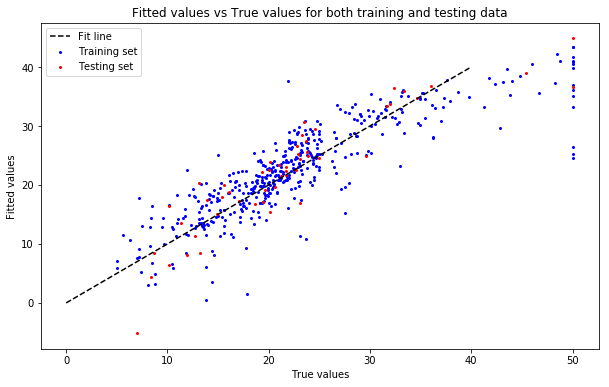

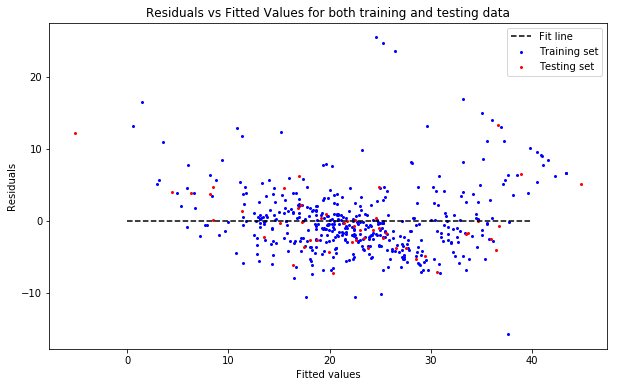

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
model.fit(X_train, y_train)

# Fitted values vs true values
plt.figure()
plt.scatter(y_train, model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(y_test, model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), np.linspace(0, 40, 1000), '--k')
plt.title('Fitted values vs True values for both training and testing data')
plt.xlabel('True values')
plt.ylabel('Fitted values')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

# Residuals vs Fitted values
plt.figure()
plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), [0 for _ in np.linspace(0, 40, 1000)], '--k')
plt.title('Residuals vs Fitted Values for both training and testing data')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

### Linear Regression with Regularization

##### LR with Ridge Regularization

Find best alpha

RMSE Testing for alpha=0 = 4.85281115300227
RMSE Testing for alpha=0.0001 = 4.852811411082219
RMSE Testing for alpha=0.001 = 4.852813782937816
RMSE Testing for alpha=0.01 = 4.8528422939700535
RMSE Testing for alpha=0.02 = 4.852883893661321
RMSE Testing for alpha=0.03 = 4.852935492553531
RMSE Testing for alpha=0.04 = 4.852996650808274
RMSE Testing for alpha=0.05 = 4.853066947347295
RMSE Testing for alpha=0.1 = 4.853541973159492
RMSE Testing for alpha=0.5 = 4.861308665000514
RMSE Testing for alpha=1.0 = 4.873042667993615
RMSE Testing for alpha=2.5 = 4.898750068730407
RMSE Testing for alpha=5.0 = 4.919969962290322
RMSE Testing for alpha=10.0 = 4.938083295775555
RMSE Testing for alpha=50.0 = 4.994501174325166
RMSE Testing for alpha=100.0 = 5.052100526174591
RMSE Testing for alpha=1000.0 = 5.418749286196122
RMSE Testing for alpha=10000.0 = 6.22250730000413


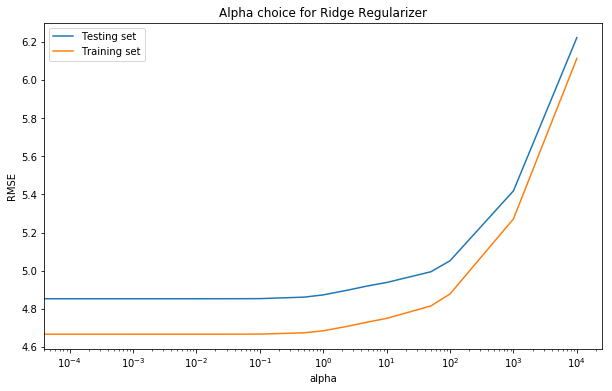

In [13]:
alphas = [0, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0, 1000.0, 10000.0]
rmse_avgs = []
rmse_avgs_train = []
for alpha in alphas:
    model = Ridge(alpha=alpha)

    kf = KFold(n_splits=10)
    rmse_per_fold_test = []
    rmse_per_fold_train = []
    for trainset, testset in kf.split(X):
        X_train, X_test = X[trainset], X[testset]
        y_train, y_test = y[trainset], y[testset]
        model.fit(X_train, y_train)
        rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
        rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))

    rmse_avgs.append(np.sqrt(np.average(rmse_per_fold_test)))
    rmse_avgs_train.append(np.sqrt(np.average(rmse_per_fold_train)))
    
for idx, alpha in enumerate(alphas):
    print('RMSE Testing for alpha={} = {}'.format(alpha, rmse_avgs[idx]))
    
plt.semilogx(alphas, rmse_avgs)
plt.semilogx(alphas, rmse_avgs_train)
plt.title('Alpha choice for Ridge Regularizer')
plt.ylabel('RMSE')
plt.xlabel('alpha')
l = plt.legend(['Testing set', 'Training set'])
plt.show()

In [14]:
alpha = 1e4
model = Ridge(alpha=alpha)

kf = KFold(n_splits=10)
rmse_per_fold_train = []
rmse_per_fold_test = []
i = 0
for trainset, testset in kf.split(X):
    X_train, X_test = X[trainset], X[testset]
    y_train, y_test = y[trainset], y[testset]
    model.fit(X_train, y_train)
    rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))
    rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
    i = i + 1
    
rmse_avg_train = np.sqrt(np.average(rmse_per_fold_train))
rmse_avg_test = np.sqrt(np.average(rmse_per_fold_test))

print('--')
print('RMSE Training average = {}'.format(rmse_avg_train))
print('RMSE Testing average  = {}'.format(rmse_avg_test))

--
RMSE Training average = 6.113310166321434
RMSE Testing average  = 6.22250730000413


In [15]:
print(model.coef_)
print(np.max(model.coef_))
print(np.min(model.coef_))
print(np.var(model.coef_))

[-7.61953020e-02  5.37196862e-02 -4.90660542e-02  1.57887833e-02
 -1.10660586e-04  9.57078550e-02  3.09699646e-02 -1.14523275e-01
  1.35969841e-01 -1.48301444e-02 -1.62546467e-01  8.59642976e-03
 -5.11503706e-01]
0.1359698410770398
-0.5115037059579471
0.024217251091972827


##### Scatter Plots

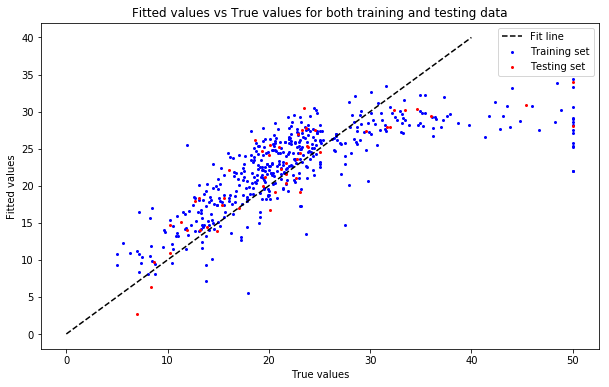

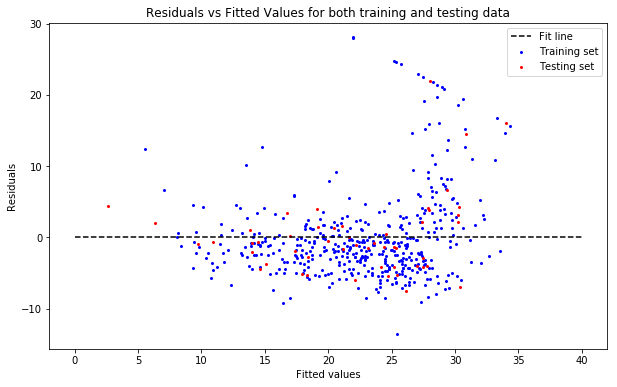

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
model.fit(X_train, y_train)

# Fitted values vs true values
plt.figure()
plt.scatter(y_train, model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(y_test, model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), np.linspace(0, 40, 1000), '--k')
plt.title('Fitted values vs True values for both training and testing data')
plt.xlabel('True values')
plt.ylabel('Fitted values')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

# Residuals vs Fitted values
plt.figure()
plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), [0 for _ in np.linspace(0, 40, 1000)], '--k')
plt.title('Residuals vs Fitted Values for both training and testing data')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

##### LR with Lasso Regularization

Find best alpha

RMSE Testing for alpha=0.0001 = 4.852835484153868
RMSE Testing for alpha=0.001 = 4.853092023983317
RMSE Testing for alpha=0.01 = 4.859184405892835
RMSE Testing for alpha=0.02 = 4.87404597989314
RMSE Testing for alpha=0.03 = 4.89693658159049
RMSE Testing for alpha=0.04 = 4.927742890353728
RMSE Testing for alpha=0.05 = 4.963428026176596
RMSE Testing for alpha=0.1 = 4.9902928087615255
RMSE Testing for alpha=0.5 = 5.072941272744268
RMSE Testing for alpha=1.0 = 5.338170044375743
RMSE Testing for alpha=2.5 = 5.867891872578891
RMSE Testing for alpha=5.0 = 6.177042334544965
RMSE Testing for alpha=10.0 = 6.427549498484539
RMSE Testing for alpha=50.0 = 8.088272324407692
RMSE Testing for alpha=100.0 = 8.146993508259143
RMSE Testing for alpha=1000.0 = 9.220199099852275
RMSE Testing for alpha=10000.0 = 9.220199099852275


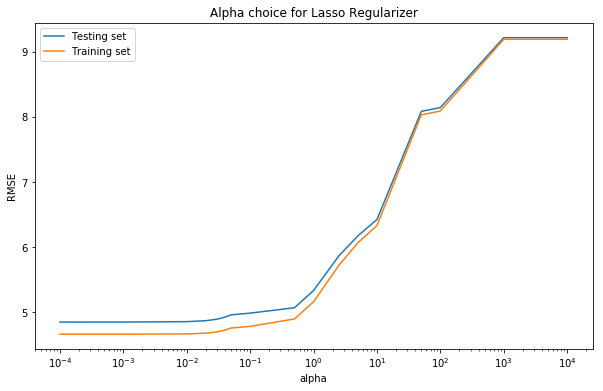

In [17]:
alphas = [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0, 1e3, 1e4]
rmse_avgs = []
rmse_avgs_train = []
for alpha in alphas:
    model = Lasso(alpha=alpha)

    kf = KFold(n_splits=10)
    rmse_per_fold_test = []
    rmse_per_fold_train = []
    for trainset, testset in kf.split(X):
        X_train, X_test = X[trainset], X[testset]
        y_train, y_test = y[trainset], y[testset]
        model.fit(X_train, y_train)
        rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
        rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))

    rmse_avgs.append(np.sqrt(np.average(rmse_per_fold_test)))
    rmse_avgs_train.append(np.sqrt(np.average(rmse_per_fold_train)))
    
for idx, alpha in enumerate(alphas):
    print('RMSE Testing for alpha={} = {}'.format(alpha, rmse_avgs[idx]))
    
plt.semilogx(alphas, rmse_avgs)
plt.semilogx(alphas, rmse_avgs_train)
plt.title('Alpha choice for Lasso Regularizer')
plt.ylabel('RMSE')
plt.xlabel('alpha')
l = plt.legend(['Testing set', 'Training set'])
plt.show()

In [29]:
alpha = 1e1
model = Lasso(alpha=alpha)

kf = KFold(n_splits=10)
rmse_per_fold_train = []
rmse_per_fold_test = []
i = 0
for trainset, testset in kf.split(X):
    X_train, X_test = X[trainset], X[testset]
    y_train, y_test = y[trainset], y[testset]
    model.fit(X_train, y_train)
    rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))
    rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
    i = i + 1
    
rmse_avg_train = np.sqrt(np.average(rmse_per_fold_train))
rmse_avg_test = np.sqrt(np.average(rmse_per_fold_test))

print('--')
print('RMSE Training average = {}'.format(rmse_avg_train))
print('RMSE Testing average  = {}'.format(rmse_avg_test))

--
RMSE Training average = 6.335918300104214
RMSE Testing average  = 6.427549498484539


In [30]:
print(model.coef_)
print(np.max(model.coef_))
print(np.min(model.coef_))
print(np.var(model.coef_))

[-0.          0.02038496 -0.          0.          0.          0.
  0.00427373 -0.          0.         -0.01025331 -0.          0.00681399
 -0.58250822]
0.020384958245535278
-0.5825082168650241
0.024282073103409026


##### Scatter Plots

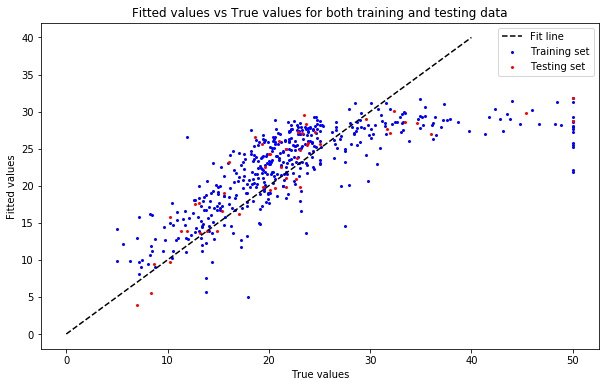

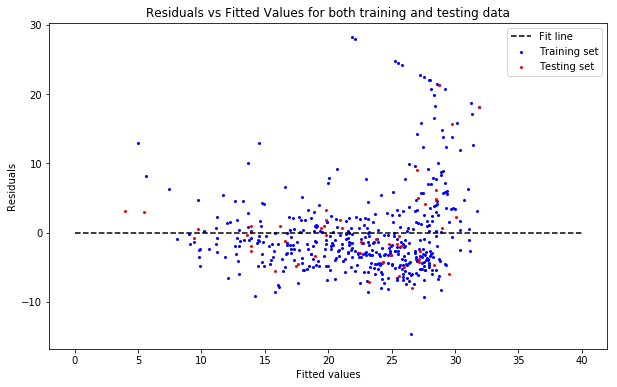

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
model.fit(X_train, y_train)

# Fitted values vs true values
plt.figure()
plt.scatter(y_train, model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(y_test, model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), np.linspace(0, 40, 1000), '--k')
plt.title('Fitted values vs True values for both training and testing data')
plt.xlabel('True values')
plt.ylabel('Fitted values')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

# Residuals vs Fitted values
plt.figure()
plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), [0 for _ in np.linspace(0, 40, 1000)], '--k')
plt.title('Residuals vs Fitted Values for both training and testing data')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

##### LR with Elastic Net Regularization

Find best $\lambda_1$ and $\lambda_2$

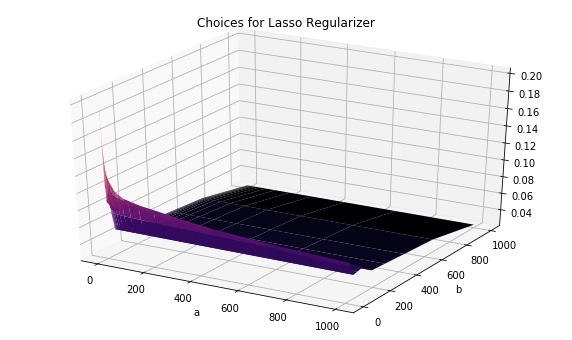

In [21]:
# a_s = [0.0001, 0.0005, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0, 1000]
# b_s = [0.0001, 0.0005, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0, 1000]
a_s = np.logspace(-4.0, 3.0, num=40)
b_s = np.logspace(-4.0, 3.0, num=40)
rmse_avgs = np.zeros((len(a_s), len(b_s)))
rmse_avgs_train = np.zeros((len(a_s), len(b_s)))
for adx, a in enumerate(a_s):
    for bdx, b in enumerate(b_s):
        alpha = a + b
        l1_ratio = a / (a + b)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

        kf = KFold(n_splits=10)
        rmse_per_fold_test = []
        rmse_per_fold_train = []
        for trainset, testset in kf.split(X):
            X_train, X_test = X[trainset], X[testset]
            y_train, y_test = y[trainset], y[testset]
            model.fit(X_train, y_train)
            rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
            rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))

        rmse_avgs[adx, bdx] = np.sqrt(np.average(rmse_per_fold_test))
        rmse_avgs_train[adx, bdx] = np.sqrt(np.average(rmse_per_fold_train))
        
from mpl_toolkits import mplot3d

def f1(x, y):
    ret = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            ret[i][j] = rmse_avgs[i][j]
    return ret

def f2(x, y):
    ret = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            ret[i][j] = rmse_avgs_train[i][j] - rmse_avgs[i][j]
    return ret

X_mesh, Y_mesh = np.meshgrid(a_s, b_s)
Z1 = f1(X_mesh, Y_mesh)
Z2 = f2(X_mesh, Y_mesh)

ax = plt.axes(projection='3d')
# ax.plot_surface(X_mesh, Y_mesh, Z1, rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none', alpha=0.5)
ax.plot_surface(X_mesh, Y_mesh, np.abs(Z2), rstride=1, cstride=1,
                cmap='inferno', edgecolor='none')

plt.ylabel('b')
plt.xlabel('a')
ax.set_title('Choices for Lasso Regularizer')
plt.show()

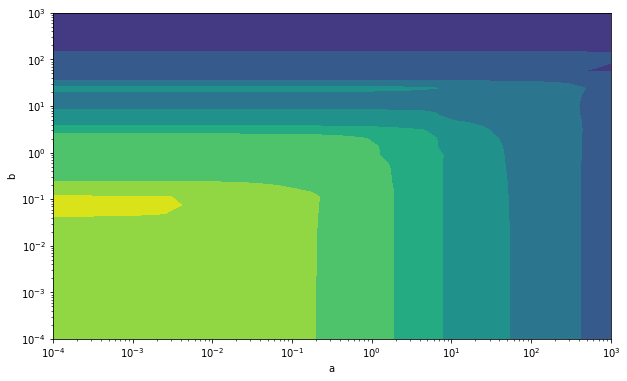

In [22]:
ax2 = plt.axes()
ax2.set_xscale("log") 
ax2.set_yscale("log")

ax2.contourf(X_mesh, Y_mesh, np.abs(Z2))
plt.ylabel('b')
plt.xlabel('a')
plt.show()

# ind = np.unravel_index(np.argmin(np.abs(Z2), axis=None), rmse_avgs.shape)
# print("Best values: a={}, b={}".format(a_s[ind[0]], b_s[ind[1]]))
# print(Z2[ind])

In [32]:
# a * L1 + b * L2
a = 1e2
b = 1e1

alpha = a + b
l1_ratio = a / (a + b)
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

kf = KFold(n_splits=10)
rmse_per_fold_train = []
rmse_per_fold_test = []
i = 0
for trainset, testset in kf.split(X):
    X_train, X_test = X[trainset], X[testset]
    y_train, y_test = y[trainset], y[testset]
    model.fit(X_train, y_train)
    rmse_per_fold_train.append(rmse(y_train, model.predict(X_train)))
    rmse_per_fold_test.append(rmse(y_test, model.predict(X_test)))
    i = i + 1
    
rmse_avg_train = np.sqrt(np.average(rmse_per_fold_train))
rmse_avg_test = np.sqrt(np.average(rmse_per_fold_test))

print('--')
print('RMSE Training average = {}'.format(rmse_avg_train))
print('RMSE Testing average  = {}'.format(rmse_avg_test))

--
RMSE Training average = 8.094212521254052
RMSE Testing average  = 8.147051909047763


In [33]:
print(model.coef_)
print(np.max(model.coef_))
print(np.min(model.coef_))
print(np.var(model.coef_))

[-0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.         -0.02164431 -0.          0.00367929
 -0.        ]
0.003679291279423403
-0.021644306868251886
3.516822407414088e-05


##### Scatter Plots

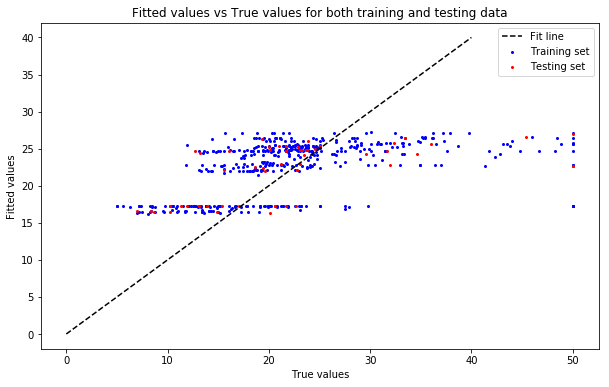

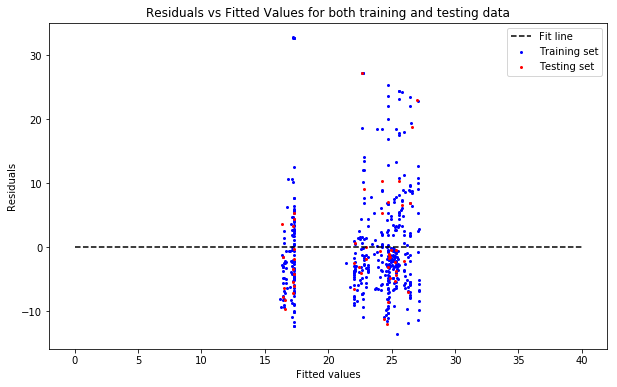

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
model.fit(X_train, y_train)

# Fitted values vs true values
plt.figure()
plt.scatter(y_train, model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(y_test, model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), np.linspace(0, 40, 1000), '--k')
plt.title('Fitted values vs True values for both training and testing data')
plt.xlabel('True values')
plt.ylabel('Fitted values')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])

# Residuals vs Fitted values
plt.figure()
plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c='b', s=4, alpha=1)
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c='r', s=4, alpha=1)
plt.plot(np.linspace(0, 40, 1000), [0 for _ in np.linspace(0, 40, 1000)], '--k')
plt.title('Residuals vs Fitted Values for both training and testing data')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
l = plt.legend(['Fit line', 'Training set', 'Testing set'])